<a href="https://colab.research.google.com/github/aja512/NLP_Transformer/blob/main/Transfer_Learning_NLP_TF_Hub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 align=left> Transfer Learning for NLP with TensorFlow Hub</h2>
---

In [ ]:
!nvidia-smi

Fri Apr 16 10:12:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
from  IPython import display

import pathlib
import shutil
import tempfile

!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

     |████████████████████████████████| 1.0MB 8.1MB/s 
Version:  2.4.1
Hub version:  0.11.0
GPU is available


## Download and Import the Quora Insincere Questions Dataset

A downloadable copy of the [Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip). Decompress and read the data into a pandas DataFrame.

In [2]:
df=pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip',compression='zip',low_memory=False)
df.shape

(1306122, 3)

In [3]:
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


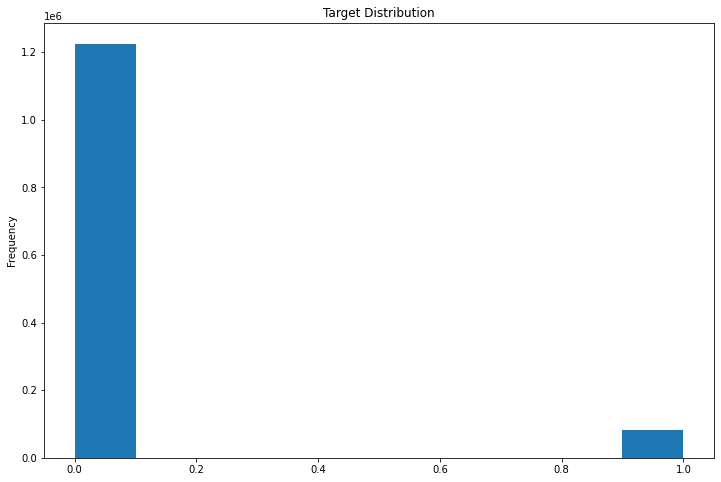

In [ ]:
df['target'].plot(kind='hist',title='Target Distribution');

In [5]:
df['word_count'] = df['question_text'].apply(lambda x: len(str(x).split()))
df['sentence_length'] = df['question_text'].apply(lambda x: len(str(x)))
df[['question_text', 'word_count', 'sentence_length']].head()

,question_text,word_count,sentence_length
0,How did Quebec nationalists see their province...,13,72
1,"Do you have an adopted dog, how would you enco...",16,81
2,Why does velocity affect time? Does velocity a...,10,67
3,How did Otto von Guericke used the Magdeburg h...,9,57
4,Can I convert montra helicon D to a mountain b...,15,77


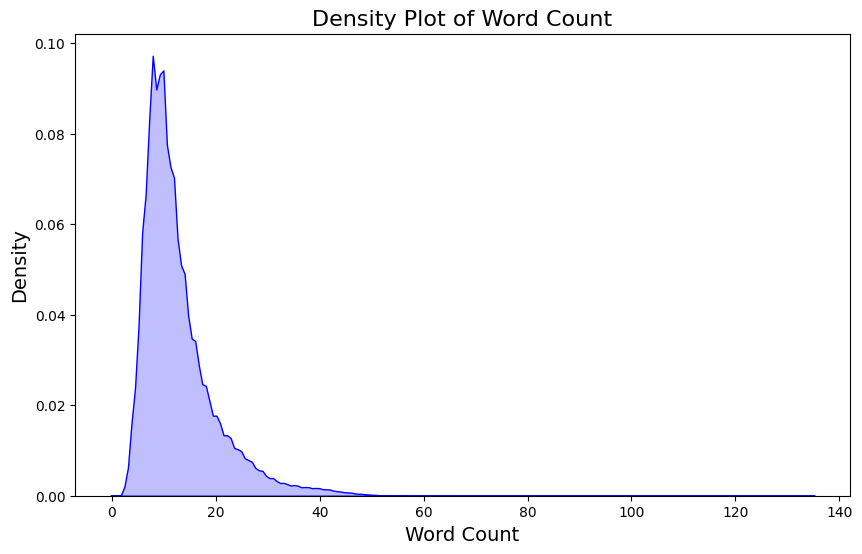

In [9]:
#denstiy plot
plt.figure(figsize=(10, 6))
sns.kdeplot(df['word_count'], fill=True, color='blue')

plt.title('Density Plot of Word Count', fontsize=16)
plt.xlabel('Word Count', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.show()

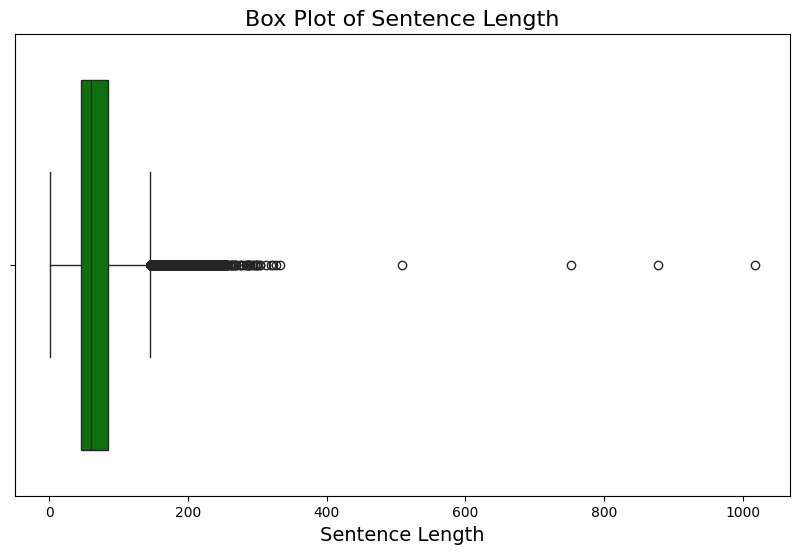

In [11]:
# box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['sentence_length'], color='green')

plt.title('Box Plot of Sentence Length', fontsize=16)
plt.xlabel('Sentence Length', fontsize=14)
plt.show()

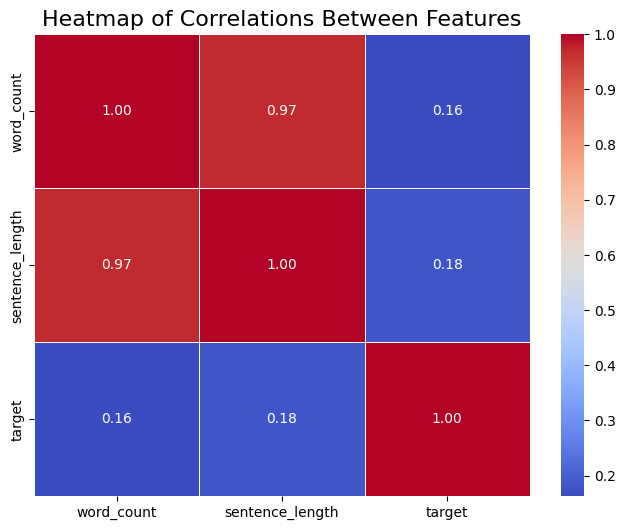

In [12]:
correlation_matrix = df[['word_count', 'sentence_length', 'target']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

plt.title('Heatmap of Correlations Between Features', fontsize=16)
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
train_df,remaining=train_test_split(df,random_state=42,train_size=0.01,stratify=df.target.values)
validation_df,_=train_test_split(remaining,random_state=42,train_size=0.001,stratify=remaining.target.values)
train_df.shape,validation_df.shape

((13061, 3), (1293, 3))

In [ ]:
train_df.target.head(15).values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [ ]:
train_df.question_text.head(15).values

array(['What is your experience living in Venezuela in the current crisis? (2018)',
       'In which state/city the price of property is highest?',
       'Do rich blacks also call poor whites, “White Trash”?',
       'Should my 5 yr old son and 2 yr old daughter spend the summer with their father, after a domestic violent relationship?',
       'Why do we have parents?',
       'Do we experience ghost like Murphy did in Interstellar?',
       'Are Estoniano women beautiful?',
       'There was a Funny or Die video called Sensitivity Hoedown that got pulled. Does anyone know why?',
       'Is it a good idea to go in fully mainstream classes, even if I have meltdowns that might disrupt people?',
       'What classifies a third world country as such?',
       'Is being a pilot safe?',
       'Who is Illiteratendra Modi? Why does he keep with him a Rs 1 lakh pen?',
       'Have modern management strategies such as Total supply Chain Management applied to education? Can they be?',
       '

## TensorFlow Hub for Natural Language Processing

Tensorflow Hub provides a number of [modules](https://tfhub.dev/s?module-type=text-embedding&tf-version=tf2&q=tf2) to convert sentences into embeddings such as Universal sentence ecoders, NNLM, BERT and Wikiwords.

In [13]:
module_url = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"

## Define Function to Build and Compile Models

In [ ]:
def train_and_evaluate_model(module_url, embed_size, name, trainable=False):
  hub_layer=hub.KerasLayer(module_url,input_shape=[],output_shape=[embed_size],dtype=tf.string,trainable=trainable)
  model=tf.keras.models.Sequential([hub_layer, tf.keras.layers.Dense(256,activation='relu'),tf.keras.layers.Dense(64,activation='relu'),tf.keras.layers.Dense(1,activation='sigmoid')])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=tf.losses.BinaryCrossentropy(),metrics=[tf.metrics.BinaryAccuracy(name='accuracy')])
  model.summary()
  history=model.fit(train_df['question_text'],train_df['target'],epochs=100,batch_size=32,validation_data=(validation_df['question_text'], validation_df['target']),callbacks=[tfdocs.modeling.EpochDots(),tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,mode='min'),tf.keras.callbacks.TensorBoard(logdir/name)],verbose=0)
  return history

## Compare Accuracy and Loss Curves

In [14]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5"

In [ ]:
histories = {}
histories['universal-sentence-encoder-large']=train_and_evaluate_model(module_url,embed_size=512,name='universal-sentence-encoder-large',trainable=False)


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 512)               147354880 
_________________________________________________________________
dense_15 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_16 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 147,502,721
Trainable params: 147,841
Non-trainable params: 147,354,880
_________________________________________________________________



Epoch: 0, accuracy:0.9247,  loss:0.3283,  val_accuracy:0.9381,  val_loss:0.1767,  
...............

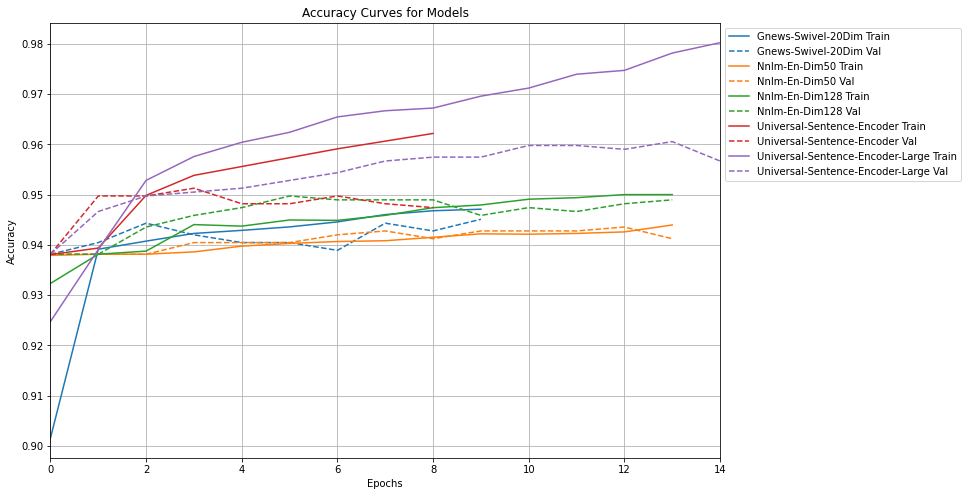

In [ ]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

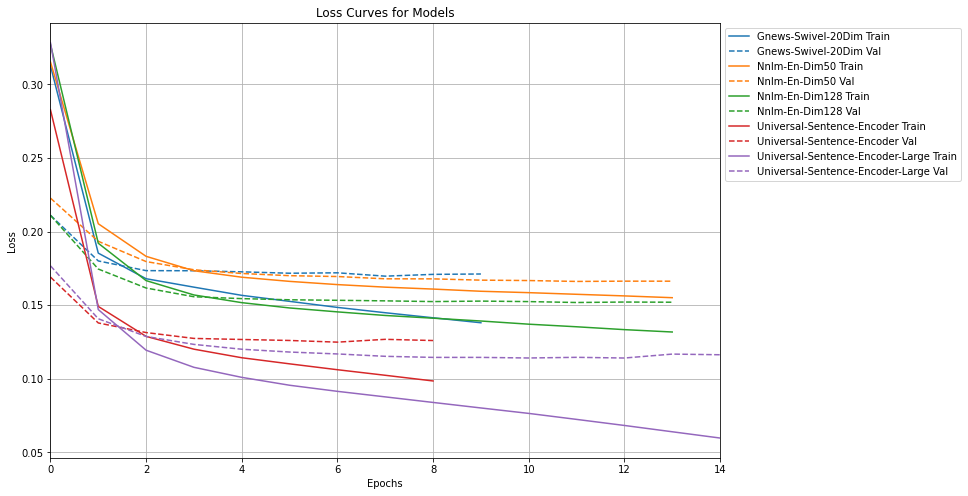

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Loss Curves for Models")
plt.show()